In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplfinance as mpf
import yfinance
import ta
from datetime import datetime
import config
import MetaTrader5 as mt5
from tqdm import tqdm
from pandas.plotting import scatter_matrix
from shapely.geometry import LineString, Point, MultiPoint

# Initialize MT5

In [2]:
if not mt5.initialize(config.PATH,
                      login=config.USERNAME,
                      password=config.PASSWORD,
                      server=config.SERVER
                      ):
    print("initialize() failed")
    mt5.shutdown()
# request connection status and parameters
print(mt5.terminal_info())
# get data on MetaTrader 5 version
print(mt5.version())

TerminalInfo(community_account=False, community_connection=False, connected=True, dlls_allowed=False, trade_allowed=False, tradeapi_disabled=False, email_enabled=False, ftp_enabled=False, notifications_enabled=False, mqid=False, build=2715, maxbars=100000, codepage=0, ping_last=0, community_balance=0.0, retransmission=0.0, company='MetaQuotes Software Corp.', name='MetaTrader 5', language='English', path='C:\\Program Files\\MetaTrader 5', data_path='C:\\Users\\ChiChaChai\\AppData\\Roaming\\MetaQuotes\\Terminal\\D0E8209F77C8CF37AD8BF550E51FF075', commondata_path='C:\\Users\\ChiChaChai\\AppData\\Roaming\\MetaQuotes\\Terminal\\Common')
(500, 2715, '26 Nov 2020')


# Import data

In [3]:
symbols = ['AUDUSDm']

start_date =  datetime(2020, 5, 1)
timeframe = mt5.TIMEFRAME_H1
dfs = []
ohlc_cols = []
for symbol in tqdm(symbols):
    df = pd.DataFrame(mt5.copy_rates_range(symbol, timeframe, start_date, datetime.now()))
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df.set_index('time', inplace=True)
    df = df[['open', 'high', 'low', 'close']]
    df.rename(columns=lambda col: f'{symbol}_{col}', inplace=True)
    ohlc_cols.extend(df.columns)
    dfs.append(df)
        
df = pd.concat(dfs, axis=1)
df

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]


,AUDUSDm_open,AUDUSDm_high,AUDUSDm_low,AUDUSDm_close
time,,,,
2020-04-30 17:00:00,0.65232,0.65289,0.65122,0.65157
2020-04-30 18:00:00,0.65157,0.65261,0.65129,0.65205
2020-04-30 19:00:00,0.65204,0.65257,0.65149,0.65149
2020-04-30 20:00:00,0.65150,0.65190,0.65071,0.65098
2020-04-30 21:00:00,0.65092,0.65102,0.64963,0.65014
...,...,...,...,...
2020-12-24 17:00:00,0.75984,0.76022,0.75970,0.76013
2020-12-24 18:00:00,0.76014,0.76036,0.75894,0.75920
2020-12-24 19:00:00,0.75918,0.75947,0.75913,0.75913


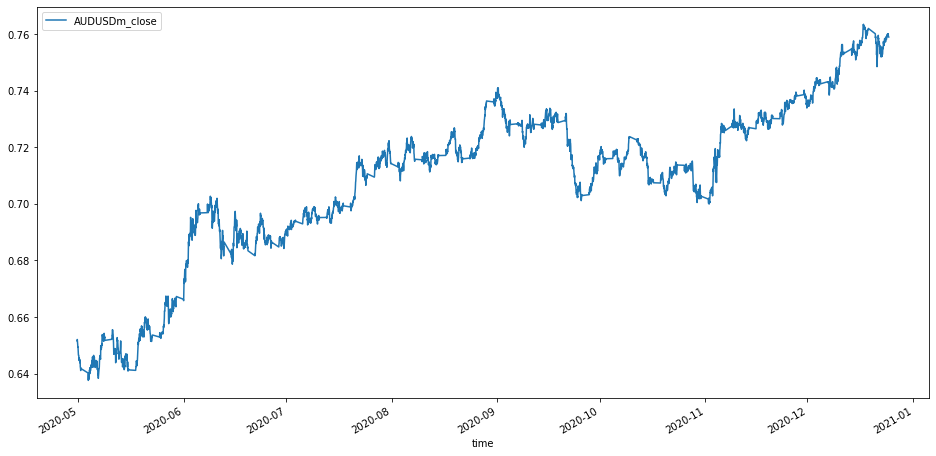

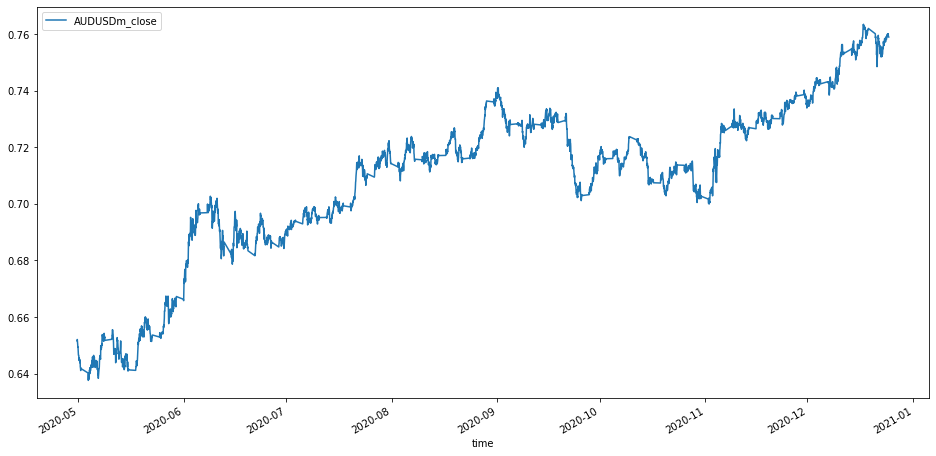

In [154]:
cols = list(map(lambda symbol: f'{symbol}_close', symbols))
trend_df = df[cols]
# trend_df.loc[:, cols] = StandardScaler().fit_transform(trend_df[cols])
trend_df.plot(figsize=(16, 8))
trend_df.loc['2020-04-01':].plot(figsize=(16, 8))

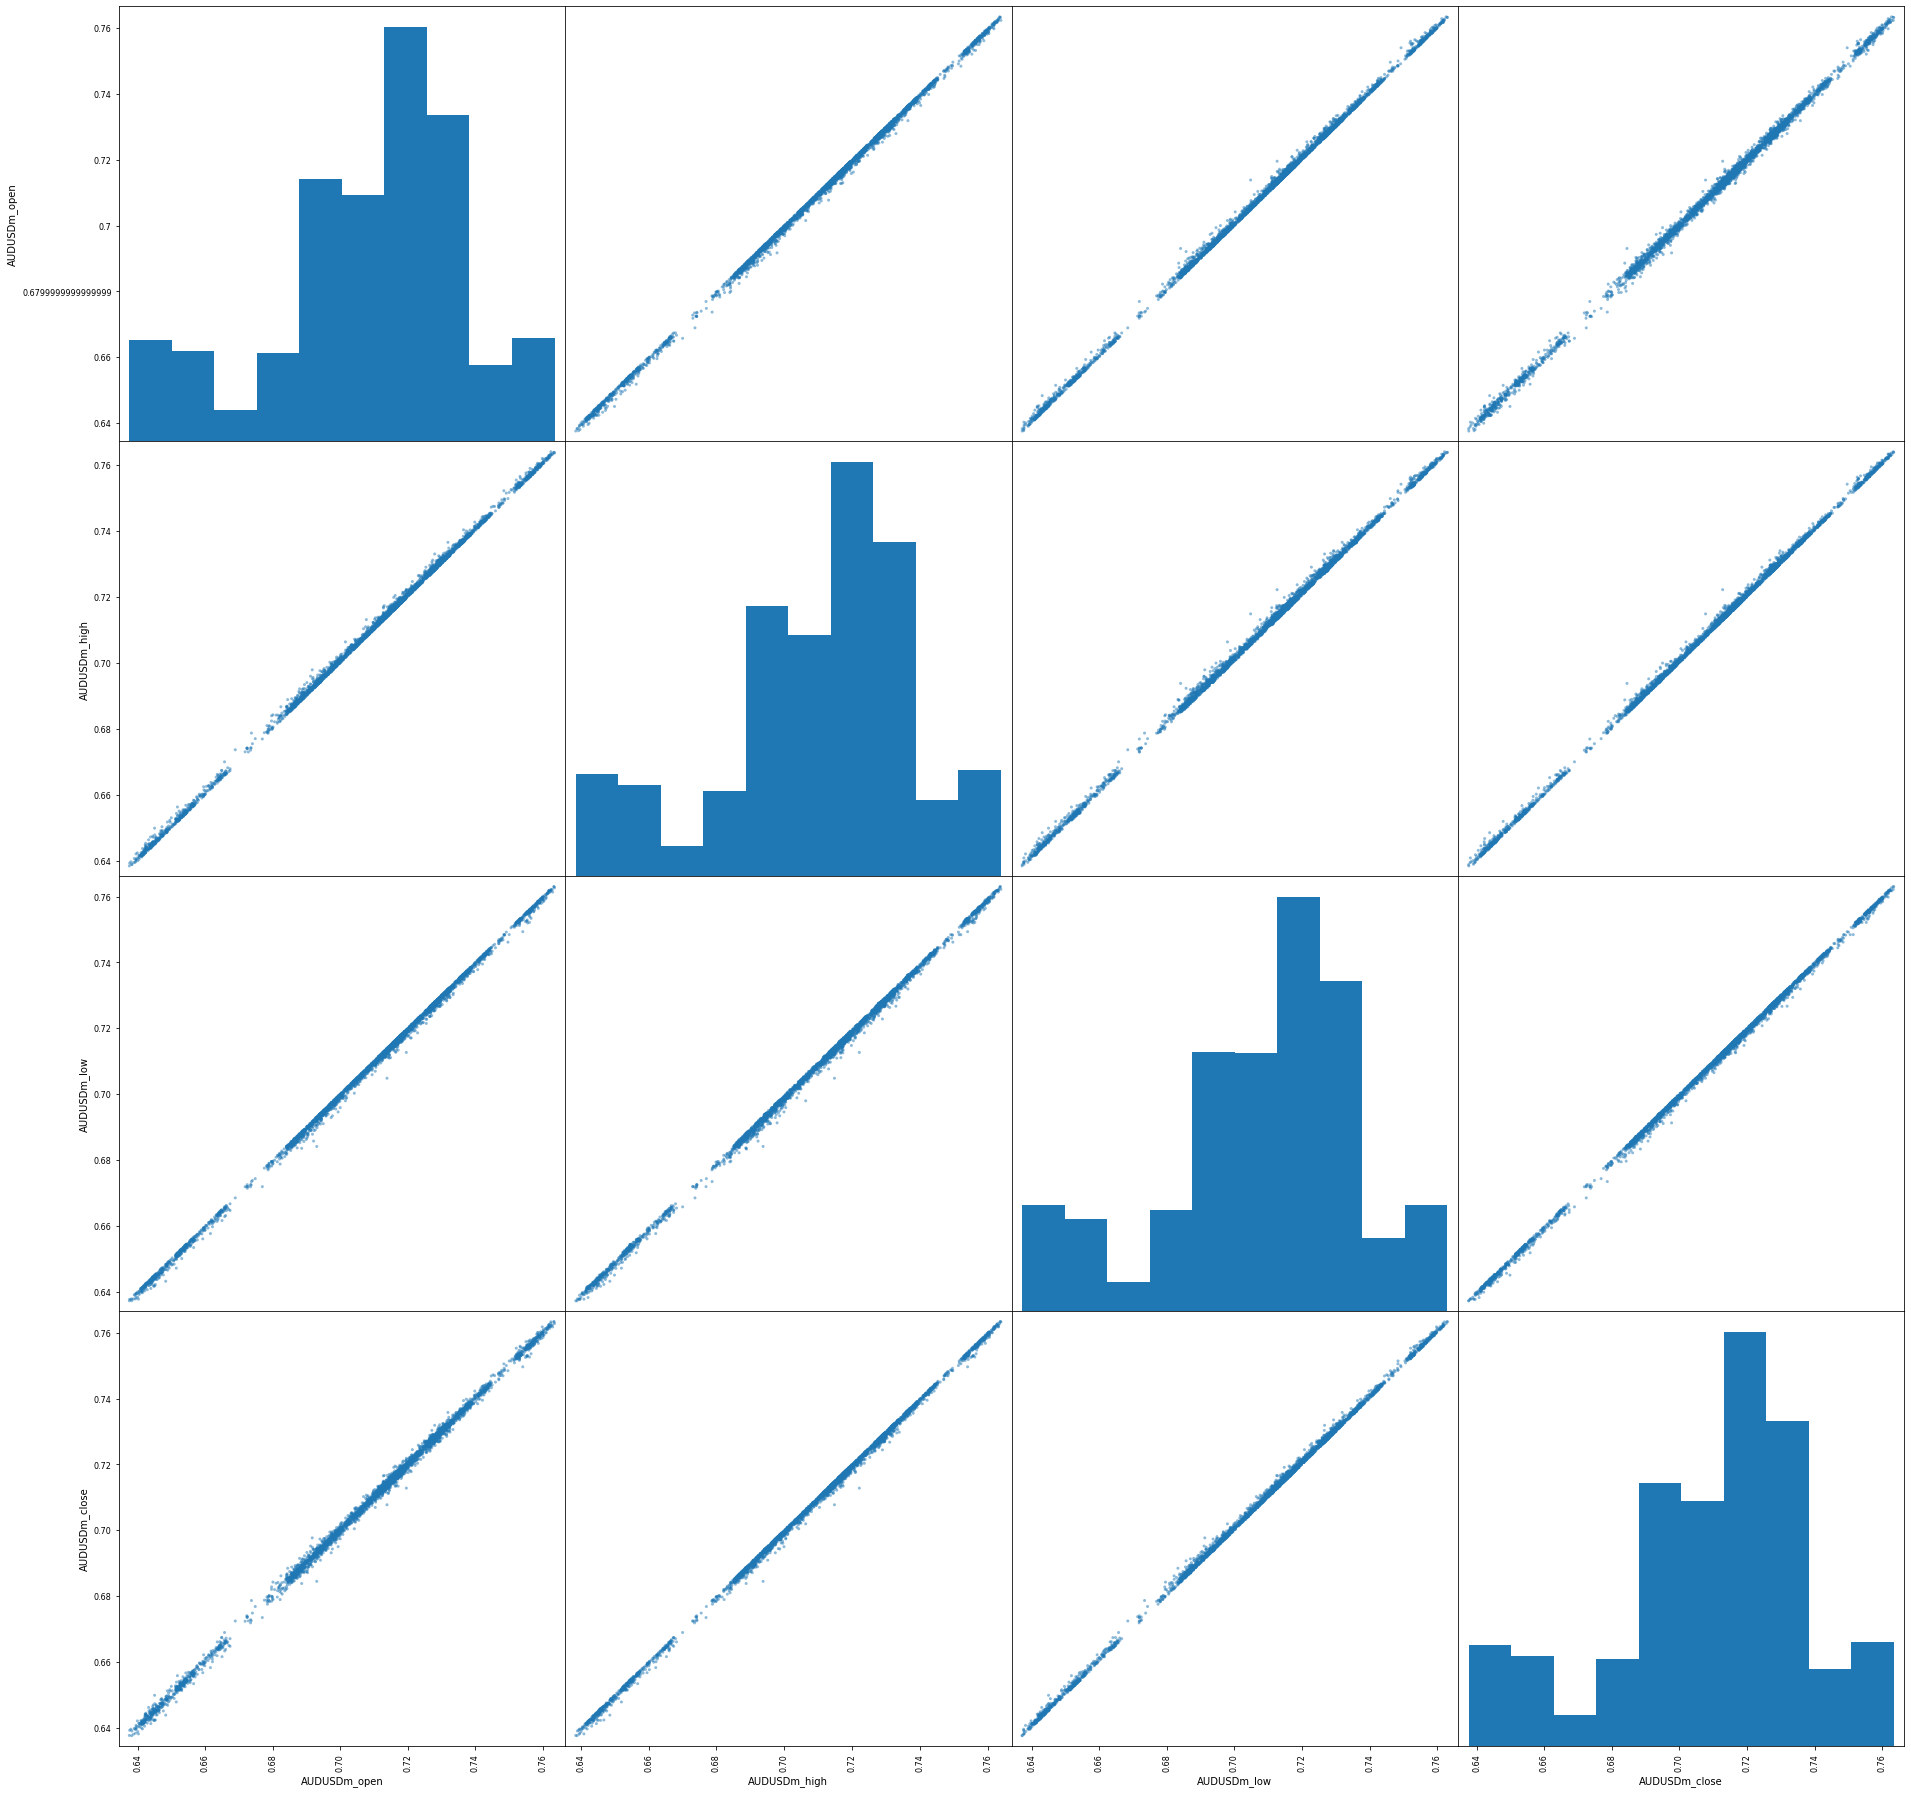

In [155]:
scatter_matrix(df, figsize=(32, 32))
plt.show()

# Pre-processing

## Define target

In [156]:

df = df.ffill()
df['return'] = df['AUDUSDm_close'].shift(-1) - df['AUDUSDm_close']

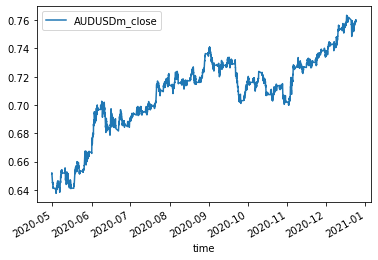

In [157]:
df.loc['2020-01-01':].plot(y='AUDUSDm_close')

In [158]:
df['next_close'] = df['AUDUSDm_close'].shift(-1)

df.tail(10)

,AUDUSDm_open,AUDUSDm_high,AUDUSDm_low,AUDUSDm_close,return,next_close
time,,,,,,
2020-12-24 12:00:00,0.75992,0.76060,0.75960,0.75980,0.00016,0.75996
2020-12-24 13:00:00,0.75980,0.76026,0.75955,0.75996,0.00015,0.76011
2020-12-24 14:00:00,0.75993,0.76039,0.75929,0.76011,-0.00048,0.75963
2020-12-24 15:00:00,0.76012,0.76029,0.75910,0.75963,0.00021,0.75984
2020-12-24 16:00:00,0.75963,0.76012,0.75947,0.75984,0.00029,0.76013
2020-12-24 17:00:00,0.75984,0.76022,0.75970,0.76013,-0.00093,0.75920
2020-12-24 18:00:00,0.76014,0.76036,0.75894,0.75920,-0.00007,0.75913
2020-12-24 19:00:00,0.75918,0.75947,0.75913,0.75913,-0.00005,0.75908
2020-12-24 20:00:00,0.75913,0.75928,0.75843,0.75908,-0.00013,0.75895


In [159]:
df.dropna(inplace=True)

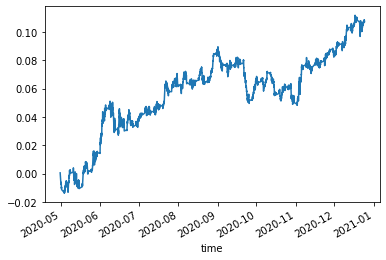

In [160]:
df['return'].cumsum().plot()

In [184]:
grid_size = 0.005
grids = np.arange(df['AUDUSDm_close'].min(), df['AUDUSDm_close'].max(), grid_size)

points = np.array([np.arange(len(df)), df['AUDUSDm_close'].tolist() ]).T
close_linestring = LineString(points)
intersection_points = []

for grid in grids:
    grid_linestring = LineString([(0, grid), (len(df), grid)])
    intersections = close_linestring.intersection(grid_linestring)
    
    # if no intersection
    if isinstance(intersections, LineString):
        continue
    
    # if intersection only single time
    if isinstance(intersections, Point):
        intersections = [intersections]
    for point in intersections:
        x, y = point.xy
        intersection_points.append(x[0])
intersection_points = np.array(intersection_points)
intersection_points = np.round(intersection_points).astype(int)
intersection_points.sort()
intersection_timestamps = df.index[intersection_points]
intersection_timestamps

DatetimeIndex(['2020-05-01 01:00:00', '2020-05-01 15:00:00',
               '2020-05-03 23:00:00', '2020-05-04 18:00:00',
               '2020-05-04 20:00:00', '2020-05-04 23:00:00',
               '2020-05-05 08:00:00', '2020-05-05 08:00:00',
               '2020-05-06 00:00:00', '2020-05-06 00:00:00',
               ...
               '2020-12-22 18:00:00', '2020-12-22 20:00:00',
               '2020-12-22 22:00:00', '2020-12-23 14:00:00',
               '2020-12-23 17:00:00', '2020-12-23 17:00:00',
               '2020-12-23 19:00:00', '2020-12-23 19:00:00',
               '2020-12-23 21:00:00', '2020-12-23 22:00:00'],
              dtype='datetime64[ns]', name='time', length=610, freq=None)

In [191]:
intersection_df = df.loc[intersection_timestamps]
intersection_df['previous_close'] = intersection_df['AUDUSDm_close'].shift(1)
intersection_df.dropna(inplace=True)

BUY = 'BUY'
SELL_ALL = 'SELL_ALL'
intersection_df['action'] = np.where(intersection_df['AUDUSDm_close'] > intersection_df['previous_close'], BUY, SELL_ALL)
intersection_df

,AUDUSDm_open,AUDUSDm_high,AUDUSDm_low,AUDUSDm_close,return,next_close,action,balance,previous_close
time,,,,,,,,,
2020-05-01 15:00:00,0.64481,0.64483,0.64177,0.64231,-0.00010,0.64221,SELL_ALL,-0.64231,0.64747
2020-05-03 23:00:00,0.63828,0.63892,0.63723,0.63759,0.00007,0.63766,SELL_ALL,-1.27990,0.64231
2020-05-04 18:00:00,0.64181,0.64301,0.64181,0.64245,0.00063,0.64308,BUY,-0.63745,0.63759
2020-05-04 20:00:00,0.64308,0.64309,0.64200,0.64249,-0.00017,0.64232,BUY,0.00504,0.64245
2020-05-04 23:00:00,0.64231,0.64304,0.64221,0.64250,0.00192,0.64442,BUY,0.64754,0.64249
...,...,...,...,...,...,...,...,...,...
2020-12-23 17:00:00,0.75846,0.75851,0.75688,0.75735,0.00065,0.75800,SELL_ALL,-43.66173,0.75735
2020-12-23 19:00:00,0.75801,0.75823,0.75719,0.75740,0.00089,0.75829,BUY,-44.41913,0.75735
2020-12-23 19:00:00,0.75801,0.75823,0.75719,0.75740,0.00089,0.75829,SELL_ALL,-44.41913,0.75740


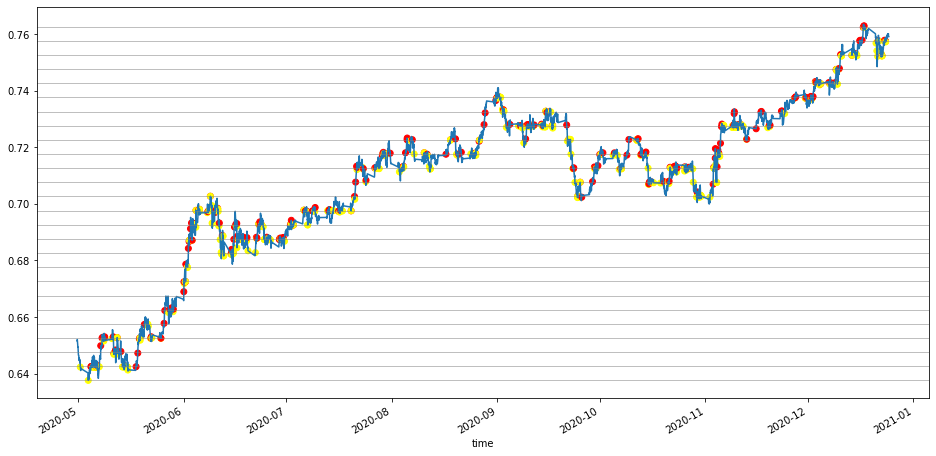

In [196]:
df['AUDUSDm_close'].plot(figsize=(16, 8))
dot_colors = {BUY: 'red', SELL_ALL: 'yellow'}
colors = list(map(lambda action: dot_colors[action], intersection_df['action']))
plt.scatter(intersection_df.index, intersection_df['AUDUSDm_close'], color=colors)
for grid in grids:
    plt.axhline(grid, color='gray', linewidth=0.5)

In [197]:
intersection_df

,AUDUSDm_open,AUDUSDm_high,AUDUSDm_low,AUDUSDm_close,return,next_close,action,balance,previous_close
time,,,,,,,,,
2020-05-01 15:00:00,0.64481,0.64483,0.64177,0.64231,-0.00010,0.64221,SELL_ALL,-0.64231,0.64747
2020-05-03 23:00:00,0.63828,0.63892,0.63723,0.63759,0.00007,0.63766,SELL_ALL,-1.27990,0.64231
2020-05-04 18:00:00,0.64181,0.64301,0.64181,0.64245,0.00063,0.64308,BUY,-0.63745,0.63759
2020-05-04 20:00:00,0.64308,0.64309,0.64200,0.64249,-0.00017,0.64232,BUY,0.00504,0.64245
2020-05-04 23:00:00,0.64231,0.64304,0.64221,0.64250,0.00192,0.64442,BUY,0.64754,0.64249
...,...,...,...,...,...,...,...,...,...
2020-12-23 17:00:00,0.75846,0.75851,0.75688,0.75735,0.00065,0.75800,SELL_ALL,-43.66173,0.75735
2020-12-23 19:00:00,0.75801,0.75823,0.75719,0.75740,0.00089,0.75829,BUY,-44.41913,0.75735
2020-12-23 19:00:00,0.75801,0.75823,0.75719,0.75740,0.00089,0.75829,SELL_ALL,-44.41913,0.75740


In [208]:
balance = 0
balance_cumsum = []

portfolio = 0
portfolio_cumsum = []
for index, grid in intersection_df.iterrows():
    if grid['action'] == BUY:
        balance -= grid['AUDUSDm_close']
        portfolio += 1
    elif grid['action'] == SELL_ALL:
        balance += grid['AUDUSDm_close'] * portfolio
        portfolio = 0
    
    balance_cumsum.append(balance)
    portfolio_cumsum.append(portfolio)

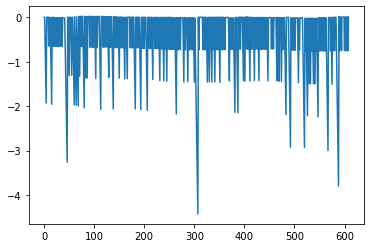

In [210]:
plt.plot(balance_cumsum)

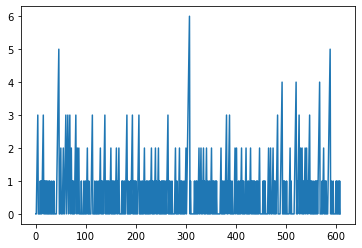

In [211]:
plt.plot(portfolio_cumsum)

In [165]:
result = test_df[['return', 'margin']]
result = result / test_df['EURUSDm_close'].values[0]


result.cumsum().plot()

NameError: name 'test_df' is not defined

In [166]:
result.resample('M', kind='period').sum().plot(kind='bar')

NameError: name 'result' is not defined

In [5]:
from fastquant import get_stock_data
df = get_stock_data("JFC", "2018-01-01", "2019-01-01")
print(df.head())

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- JFC: Data doesn't exist for startDate = 1514739600, endDate = 1546275600
Empty DataFrame
Columns: [open, high, low, close, volume]
Index: []


In [6]:
import backtrader